In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import copy 
#
from matplotlib import gridspec
from backtesting import Backtest, Strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def get_historical_data(ticker, period):
    d = yf.Ticker(ticker)
    df = d.history(period=period)
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [3]:
_df = get_historical_data('2454.TW', '8y')
_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2014-06-03,373.466959,374.219158,368.201563,370.082062,6744000,0.0,0
2014-06-04,372.338694,373.843092,368.953796,368.953796,4716000,0.0,0
2014-06-05,369.329862,382.869450,368.201563,381.365051,10437000,0.0,0
2014-06-06,381.365035,381.365035,375.723540,376.099640,4568000,0.0,0
2014-06-09,383.621676,386.630473,381.365078,382.869476,5933000,0.0,0
...,...,...,...,...,...,...,...
2022-05-25,833.000000,848.000000,826.000000,843.000000,3229937,0.0,0
2022-05-26,849.000000,849.000000,832.000000,833.000000,3458958,0.0,0
2022-05-27,842.000000,852.000000,838.000000,851.000000,3283990,0.0,0


In [4]:
tw_df = get_historical_data('^TWII', '5y')
tw_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-31,10095.950195,10116.129883,10025.879883,10040.719727,2713500,0,0
2017-06-01,10064.440430,10100.370117,10059.929688,10087.419922,1983100,0,0
2017-06-02,10117.759766,10152.530273,10117.059570,10152.530273,2100600,0,0
2017-06-05,10164.889648,10226.839844,10164.889648,10226.839844,2208100,0,0
2017-06-06,10213.169922,10221.639648,10190.389648,10206.179688,2078600,0,0
...,...,...,...,...,...,...,...
2022-05-25,15987.740234,16169.179688,15980.900391,16104.030273,3107300,0,0
2022-05-26,16128.209961,16179.009766,15949.610352,15968.830078,3062100,0,0
2022-05-27,16075.910156,16266.219727,16075.910156,16266.219727,2951400,0,0


In [5]:
from datetime import date

def cut_data(df, split_day):
    date = df.index[-1]
    date = date - pd.Timedelta(days = split_day)
    train_df = df.loc[:date, :]
    test_df = df.loc[date:, :]
    
    return train_df, test_df

train_df, test_df = cut_data(_df, 365*5)

In [6]:
train_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2014-06-03,373.466959,374.219158,368.201563,370.082062,6744000,0.0,0
2014-06-04,372.338694,373.843092,368.953796,368.953796,4716000,0.0,0
2014-06-05,369.329862,382.869450,368.201563,381.365051,10437000,0.0,0
2014-06-06,381.365035,381.365035,375.723540,376.099640,4568000,0.0,0
2014-06-09,383.621676,386.630473,381.365078,382.869476,5933000,0.0,0
...,...,...,...,...,...,...,...
2017-05-24,183.329324,187.622751,182.041296,185.905380,15510000,0.0,0
2017-05-25,192.774868,197.926981,189.769470,196.209610,23568000,0.0,0
2017-05-26,197.068283,198.356311,195.350912,197.068283,12758000,0.0,0


In [7]:
class RSI_EMA(Strategy):
    
    n1 = 20 # 20
    n2 = 50 # 50
    n3 = 5 # 5
    
    def init(self): 
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)
        signal_short = (rsi.shift() > 70) & (ema1 < ema2)
        
        # combine long and short signals
        signal = signal_long.copy()
        signal[signal_short] = -1
        signal = signal.shift(5)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        
        if entry_size > 0:    
            self.buy()
            
        elif entry_size < 0:
            for trade in self.trades:
                trade.close()
#             self.sell()

## 原參數 
### Time period 2019-05-13 ~ 2022-05-10
### n1 = 20, n2 = 50, n3 = 5

In [8]:
bt_rsi_ema = Backtest(test_df, RSI_EMA)
result_rsi_ema = bt_rsi_ema.run()
bt_rsi_ema.plot()

Row(id='1586', ...)

In [9]:
instance_variables = vars(result_rsi_ema)
print(instance_variables)

{'_is_copy': None, '_mgr': SingleBlockManager
Items: Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'Sharpe Ratio',
       'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown [%]',
       'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration',
       '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration',
       'Profit Factor', 'Expectancy [%]', 'SQN', '_strategy', '_equity_curve',
       '_trades'],
      dtype='object')
ObjectBlock: 30 dtype: object, '_item_cache': {}, '_attrs': {}, '_flags': <Flags(allows_duplicate_labels=True)>, '_name': None, '_index': Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', '

## 樣本內 最佳化
### Time period 2014-05-11 ~ 2019-05-12

In [10]:
bt_rsi_ema_train = Backtest(train_df, RSI_EMA)
result_opt_train = bt_rsi_ema_train.optimize(n1 = range(5, 30, 5),
                                             n2 = range(5, 70, 5),
                                             n3 = range(5, 30, 5),
                                             method = 'grid',  # grid, skopt
                                             maximize = 'Equity Final [$]'
                                            )
result_opt_train._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 325 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy RSI_EMA(n1=25,n2=20,n3=10)>

## 樣本外 測試
### Time period 2019-05-13 ~ 2022-05-10
### n1 = 10, n2 = 60, n3 = 10

In [11]:
bt_rsi_ema_opt = Backtest(test_df, RSI_EMA)
result_opt_test = bt_rsi_ema_opt.run()

bt_rsi_ema_opt.plot()

Row(id='2562', ...)

## 最佳化前後比較

<AxesSubplot:>

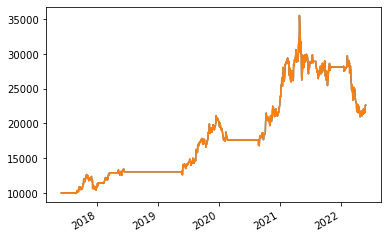

In [12]:
result_rsi_ema._equity_curve.Equity.plot()
result_opt_test._equity_curve.Equity.plot()

In [13]:
result_rsi_ema

Start                     2017-06-01 00:00:00
End                       2022-05-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                   56.521739
Equity Final [$]                 22634.600929
Equity Peak [$]                  35528.333962
Return [%]                         126.346009
Buy & Hold Return [%]               362.25294
Return (Ann.) [%]                     18.3971
Volatility (Ann.) [%]               31.114053
Sharpe Ratio                         0.591279
Sortino Ratio                        1.089215
Calmar Ratio                         0.447876
Max. Drawdown [%]                  -41.076322
Avg. Drawdown [%]                   -4.926898
Max. Drawdown Duration      397 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                    7
Win Rate [%]                        71.428571
Best Trade [%]                      65.221494
Worst Trade [%]                         -20.0
Avg. Trade [%]                    

In [14]:
result_opt_test

Start                     2017-06-01 00:00:00
End                       2022-05-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                   56.521739
Equity Final [$]                 22634.600929
Equity Peak [$]                  35528.333962
Return [%]                         126.346009
Buy & Hold Return [%]               362.25294
Return (Ann.) [%]                     18.3971
Volatility (Ann.) [%]               31.114053
Sharpe Ratio                         0.591279
Sortino Ratio                        1.089215
Calmar Ratio                         0.447876
Max. Drawdown [%]                  -41.076322
Avg. Drawdown [%]                   -4.926898
Max. Drawdown Duration      397 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                    7
Win Rate [%]                        71.428571
Best Trade [%]                      65.221494
Worst Trade [%]                         -20.0
Avg. Trade [%]                    